## Traveling Salesperson

In [39]:
from tsp import get_distance_matrices, TSP
import numpy as np 
from qiskit.result import QuasiDistribution



def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)


def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution) or isinstance(state_vector, dict):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


distances = get_distance_matrices([3])
distances = distances['dense']['low']
# distances

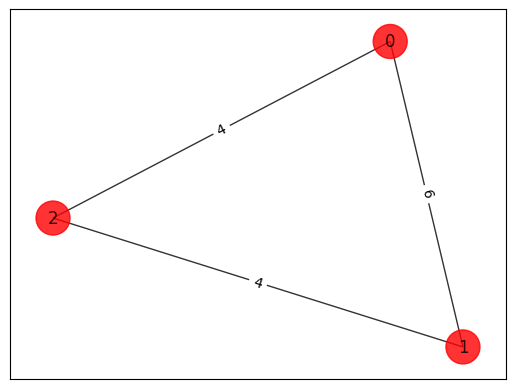

In [40]:
tsp = TSP.from_distance_matrix(distances['3'])
tsp.draw_cities()

In [41]:
tsp.brute_force()

((0, 1, 2), np.int64(14))

## Making QUBO

In [42]:
qubo = tsp.qubo(format="ising", penalty=15)
qubo

{'model': SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
               coeffs=[-20. +0.j, -20. +0.j, -20. +0.j, -20. +0.j, -20. +0.j, -20. +0.j,
  -19. +0.j, -19. +0.j, -19. +0.j,   7.5+0.j,   7.5+0.j,   7.5+0.j,
    1.5+0.j,   1.5+0.j,   7.5+0.j,   1. +0.j,   1. +0.j,   7.5+0.j,
    1.5+0.j,   7.5+0.j,   1.5+0.j,   1. +0.j,   7.5+0.j,   1. +0.j,
    1.5+0.j,   1.5+0.j,   7.5+0.j,   1. +0.j,   1. +0.j,   7.5+0.j,
    7.5+0.j,   7.5+0.j,   7.

## Solve

### Classical

In [43]:
from qiskit_algorithms import NumPyMinimumEigensolver

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubo["model"])

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + qubo['offset'])
x = sample_most_likely(result.eigenstate)

z = tsp.interpret(x, 'Qiskit')
print("solution:", z)


energy: -97.0
tsp objective: 14.0
solution: (1, 0, array([1., 2., 0.]))


In [44]:

objective_func_vals = []
iteration = 0
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    global iteration
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    # print(f"{cost=}, {iteration=}")


    return cost

In [45]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from qiskit.circuit.library import QAOAAnsatz


reps = 1000
circuit = QAOAAnsatz(cost_operator=qubo['model'], reps=reps)

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
estimator = Estimator()

# Set simple error suppression/mitigation options
result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, qubo['model'] , estimator),
    method="COBYLA",
    tol=1000,
)
print(f'{result}')


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -7.936338218550443e-14
       x: [ 3.142e+00  1.571e+00 ...  3.142e+00  1.571e+00]
    nfev: 1000
   maxcv: 0.0


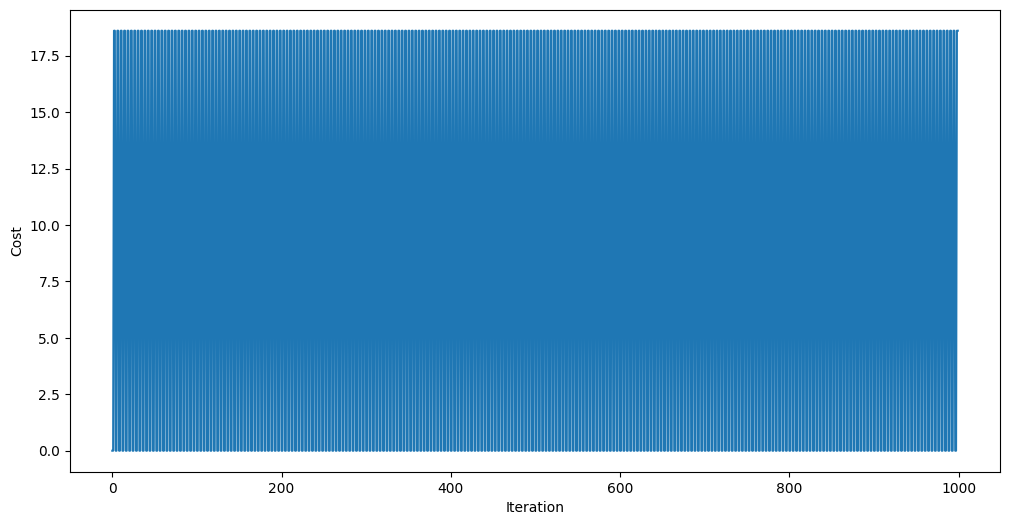

cost:  18.60349073471699


In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

print("cost: ", objective_func_vals[-1])

In [47]:
from qiskit.primitives import StatevectorSampler as Sampler
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`

optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()

sampler = Sampler(default_shots=1024)


pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{426: 0.0021, 363: 0.0023, 178: 0.002, 216: 0.0019, 173: 0.0014, 24: 0.0018, 135: 0.0016, 416: 0.0018, 6: 0.0013, 494: 0.0012, 68: 0.0019, 222: 0.0025, 495: 0.003, 109: 0.002, 91: 0.0021, 5: 0.0033, 272: 0.0022, 79: 0.0019, 73: 0.0017, 470: 0.0011, 358: 0.003, 278: 0.0016, 40: 0.0017, 380: 0.0021, 353: 0.0023, 168: 0.0027, 180: 0.0025, 56: 0.003, 493: 0.0016, 18: 0.0017, 405: 0.0031, 153: 0.0015, 488: 0.002, 267: 0.0024, 307: 0.002, 283: 0.0014, 250: 0.0025, 104: 0.0019, 455: 0.0027, 297: 0.0028, 480: 0.0018, 133: 0.0021, 87: 0.0017, 215: 0.0021, 25: 0.0027, 111: 0.0022, 165: 0.0018, 510: 0.0024, 83: 0.0015, 467: 0.0023, 194: 0.0024, 175: 0.0017, 346: 0.0011, 423: 0.0019, 138: 0.0024, 193: 0.0015, 127: 0.0018, 237: 0.0028, 438: 0.0022, 471: 0.0017, 462: 0.0022, 147: 0.0029, 120: 0.0021, 424: 0.0031, 464: 0.0018, 132: 0.0022, 485: 0.0019, 299: 0.0019, 39: 0.0024, 383: 0.0014, 331: 0.0026, 286: 0.0019, 59: 0.0015, 212: 0.0017, 437: 0.003, 234: 0.0019, 280: 0.0014, 51: 0.0023, 450: 0.0021

In [48]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, tsp.n**2)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)


Result bitstring: [1, 0, 1, 0, 0, 0, 0, 0, 0]


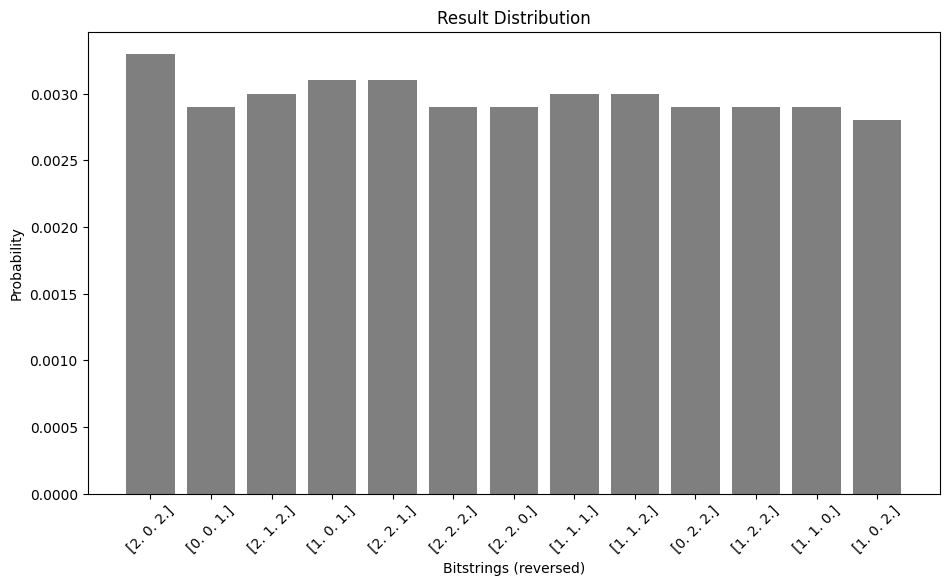

In [49]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))

final_bits_reduced = {str(tsp.interpret(list(map(int, key)), 'Qiskit')[-1]): value for key, value in sorted(final_bits.items(), key= lambda x: x[1], reverse=True)[:20]}

# key = tuple(final_bits_reduced.keys())[0]
# print()


fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits_reduced.keys()), list(final_bits_reduced.values()), color="tab:grey")

plt.show()